# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

/Users/mdeblaauw/anaconda3/envs/research-paper/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

# Hyperparameter setting

In [35]:
dim_num_batch_size = Integer(low=16, high=256, name='num_batch_size')
dim_num_epochs = Integer(low=1, high=15, name='num_epochs')
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='reg_layer1')

In [36]:
dimensions = [dim_num_epochs,
              dim_num_batch_size,
              dim_learning_rate]

In [43]:
default_parameters = [3, 32, 0.0001]

In [38]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

# Load data

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../../Tensorflow-applications/MNIST_data/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [39]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


# Hyper-parameter Optimization

In [40]:
def create_conv_layer(input_data, num_input_channels, num_filters, filter_shape, pool_shape, name):
    conv_filter_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]
    weights = tf.Variable(tf.truncated_normal(conv_filter_shape, stddev=0.03), name=name+"_W")
    bias = tf.Variable(tf.truncated_normal([num_filters], stddev=0.01), name = name+"_b")
    
    out_layer = tf.nn.conv2d(input_data, weights, [1,1,1,1], padding = 'SAME')
    out_layer_bias = tf.add(out_layer, bias)
    
    out_layer_activation = tf.nn.relu(out_layer_bias)
    
    out_layer_pooling = tf.nn.max_pool(out_layer_activation, ksize = [1,pool_shape[0], pool_shape[1], 1], strides = [1,2,2,1], padding = 'VALID')
    
    return(out_layer_pooling)

# Dense layers

In [41]:
def create_dense_layer(input_data, dense_shape, name):
    W = tf.Variable(tf.truncated_normal([dense_shape[0], dense_shape[1]], stddev=0.03), name=name+'Wd')
    b = tf.Variable(tf.truncated_normal([dense_shape[1]], stddev=0.01), name=name+'bd')
    fc = tf.add(tf.matmul(input_data, W), b)
    fc_act = tf.nn.relu(fc)
    
    return(fc_act)

## Setup training

In [47]:
@use_named_args(dimensions=dimensions)
def fitness(num_epochs, num_batch_size, learning_rate):
    
    # Print the hyper-parameters.
    print('epochs:', num_epochs)
    print('batch_size:', num_batch_size)
    print('learning rate:', learning_rate)
    print()
    
    epochs = num_epochs
    batch_size = num_batch_size
    learning_rate = learning_rate
    
    X = tf.placeholder(tf.float32, [None, 784])
    X_reshape = tf.reshape(X, [-1, 28, 28, 1])
    y = tf.placeholder(tf.float32, [None, 10])
    
    layer1 = create_conv_layer(X_reshape, 1, 16, [5,5], [2,2], name = 'layer1')
    layer2 = create_conv_layer(layer1, 16, 32, [5,5], [2,2], name = 'layer2')
    
    flat = tf.reshape(layer2, [-1, 7*7*32])
    fc1 = create_dense_layer(flat, [7*7*32, 245], name='fc1')
    fc2 = create_dense_layer(fc1, [245, 10], name = 'fc2')
    
    y_estimate = tf.nn.softmax(fc2,axis=1)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = fc2, labels=y))
    optimiser = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(y,axis=1), tf.argmax(y_estimate, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype = tf.float32))
    
    init_op = tf.global_variables_initializer()
    
    test_acc = 0
    
    with tf.Session() as sess:
        sess.run(init_op)
        total_batch = int(len(mnist.train.images)/batch_size)
        for epoch in range(epochs):
            avg_cost = 0
            for i in range(total_batch):
                batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
                a, c= sess.run([optimiser, cross_entropy], feed_dict={X: batch_x, y: batch_y})
                avg_cost += c/total_batch
            print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
        test_acc = sess.run(accuracy, feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print()
        print("Test accuracy:", test_acc)
        print()
    return(-test_acc)

In [48]:
fitness(x=default_parameters)

epochs: 3
batch_size: 32
learning rate: 0.0001

Epoch: 1 cost = 1.308
Epoch: 2 cost = 1.074
Epoch: 3 cost = 1.037

Test accuracy: 0.58



-0.58

In [26]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=12,
                            x0=default_parameters)

epochs: 2
batch_size: 32
learning rate: 1e-05

Epoch: 1 cost = 1.536
Epoch: 2 cost = 1.140

Test accuracy: 0.5878

epochs: 10
batch_size: 75
learning rate: 0.00024213211734243687

Epoch: 1 cost = 1.900
Epoch: 2 cost = 1.850
Epoch: 3 cost = 1.843
Epoch: 4 cost = 1.840
Epoch: 5 cost = 1.836
Epoch: 6 cost = 1.836
Epoch: 7 cost = 1.834
Epoch: 8 cost = 1.833
Epoch: 9 cost = 1.833
Epoch: 10 cost = 1.830

Test accuracy: 0.3004

epochs: 7
batch_size: 97
learning rate: 3.6308379317182094e-05

Epoch: 1 cost = 1.239
Epoch: 2 cost = 0.872
Epoch: 3 cost = 0.816
Epoch: 4 cost = 0.785
Epoch: 5 cost = 0.765
Epoch: 6 cost = 0.751
Epoch: 7 cost = 0.740

Test accuracy: 0.7945

epochs: 9
batch_size: 209
learning rate: 0.000328733080919149

Epoch: 1 cost = 1.230
Epoch: 2 cost = 1.033
Epoch: 3 cost = 1.008
Epoch: 4 cost = 0.993
Epoch: 5 cost = 0.985
Epoch: 6 cost = 0.977
Epoch: 7 cost = 0.976
Epoch: 8 cost = 0.971
Epoch: 9 cost = 0.968

Test accuracy: 0.5816

epochs: 10
batch_size: 211
learning rate: 6.3812

In [29]:
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

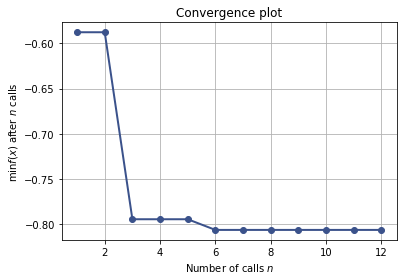

In [30]:
plot_convergence(search_result)

In [31]:
search_result.x

[7, 53, 0.00016897232783793698]

In [33]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.8063, [7, 53, 0.00016897232783793698]),
 (-0.7945, [7, 97, 3.6308379317182094e-05]),
 (-0.7669, [9, 94, 7.036859000171686e-06]),
 (-0.7455, [2, 156, 2.4403209896426415e-05]),
 (-0.7351, [10, 211, 6.381273223540004e-06]),
 (-0.6933, [5, 75, 0.00015148136225585533]),
 (-0.5878, [2, 32, 1e-05]),
 (-0.5816, [9, 209, 0.000328733080919149]),
 (-0.4921, [10, 163, 0.0002714882625493607]),
 (-0.3766, [7, 161, 1e-06]),
 (-0.3004, [10, 75, 0.00024213211734243687]),
 (-0.098, [10, 180, 0.005567723915222074])]